# 14. 포트폴리오 구성 전략

종목별로 비중을 어떻게 배분하느냐에 따라 성과가 달라지므로, 종목의 선택 못지 않게 중요한 것이 포트폴리오를 구성하는 방법입니다. 최적 포트폴리오의 구성은 수식을 기반으로 최적화된 해를 찾습니다. 물론 엑셀의 해 찾기와 같은 기능을 사용해 간단한 형태의 최적화 구현이 가능하지만, 방대한 데이터를 다룰 경우에는 속도가 지나치게 느려지거나 계산할 수 없게 되기도 합니다. 동일한 최적화 방법을 지속적으로 사용한다면 프로그래밍을 통해 함수를 만들고, 입력 변수만 변경하는 것이 훨씬 효율적인 방법입니다. 

이번 장에서는 일반적으로 많이 사용되는 최소분산 포트폴리오, 위험균형 포트폴리오를 구현해보도록 합니다. 먼저 포트폴리오 구성을 위해 글로벌 자산을 대표하는 ETF 데이터를 다운로드하겠습니다.

In [1]:
import pandas_datareader as web
import pandas as pd

tickers = ['SPY', # 미국 주식
           'IEV', # 유럽 주식 
           'EWJ', # 일본 주식
           'EEM', # 이머징 주식
           'TLT', # 미국 장기채
           'IEF', # 미국 중기채
           'IYR', # 미국 리츠
           'RWX', # 글로벌 리츠
           'GLD', # 금
           'DBC'  # 상품
            ]

all_data = {}
for ticker in tickers:
    all_data[ticker] = web.DataReader(ticker, 'yahoo', start = '2000-01-01')
    
prices = pd.DataFrame({tic: data['Adj Close'] for tic, data in all_data.items()})
prices.to_csv('data/asset_data.csv')    

`web.DataReader()` 함수를 통해 일반적으로 자산배분에서 많이 사용되는 주식과 채권, 대체자산에 해당하는 ETF 가격 데이터를 받은 후 수정주가만을 선택하여 데이터프레임 형태로 만들어 줍니다. 그 후, 파일을 csv 파일로 저장합니다.

In [2]:
prices = pd.read_csv('data/asset_data.csv', index_col = 0)
rets = prices.pct_change(1).dropna()

rets.tail()

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
Date,,,,,,,,,,
2021-04-12,0.000365,-0.005199,-0.006172,-0.005976,-0.000436,-0.000616,0.005428,-0.001699,-0.006064,0.000596
2021-04-13,0.002964,0.005614,0.006355,0.004133,0.007494,0.004140,0.006034,0.008508,0.007086,0.010721
2021-04-14,-0.003415,-0.000962,-0.001866,0.005051,-0.003177,-0.001228,-0.006103,0.007593,-0.004344,0.022982
2021-04-15,0.010742,0.008863,0.004745,0.009121,0.016734,0.006411,0.017679,0.005582,0.016163,0.006336
2021-04-16,0.002068,0.007830,0.000143,0.002232,-0.007054,-0.001745,-0.001144,0.006106,0.007912,-0.001723


csv 파일을 불러온 후 `pct_change()` 함수를 통해 수익률을 계산합니다. 또한 `dropna()` 함수를 통해 NA 데이터는 삭제해줍니다.

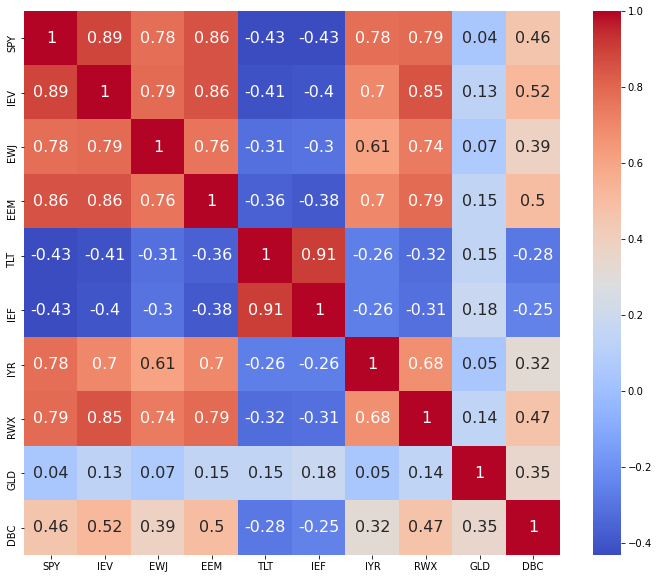

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(rets.corr().round(2), annot = True, annot_kws = {"size" : 16}, cmap='coolwarm')
plt.show()

각 ETF의 수익률 간 상관관계를 살펴보면 같은 자산군 내에서는 강한 상관관계를 보이며, 주식과 채권 간에는 매우 낮은 상관관계를 보입니다. 또한 주식과 리츠 간에도 꽤 높은 상관관계를 보입니다.

포트폴리오 최적화에는 분산-공분산 행렬이 대부분 사용되며, 이는 `cov()` 함수를 통해 손쉽게 계산할 수 있습니다.

In [4]:
covmat = pd.DataFrame.cov(rets)

## 14.1 최소분산 포트폴리오

최소분산 포트폴리오(Minimum Variance Portfolio)는 변동성이 최소인 포트폴리오입니다. 포트폴리오의 변동성은 일반적으로 $\sum_{i=1}^{n}\sum_{j=1}^{n}w_iw_j\sigma_{ij}$의 형태로 표현되지만, 최적화 작업을 위해서는 행렬의 형태인 $w'\Omega w$로 표현하는 것이 더욱 편리합니다. 이 중 $w$는 각 자산들의 비중을 행렬의 형태로 나타낸 것이며, $\Omega$는 분산-공분산 행렬을 나타낸 것입니다. 분산-공분산 행렬은 사전에 고정되어 있는 값이므로, 각 자산들의 비중인 $w$를 변화시킴으로써 포트폴리오의 변동성이 최소인 지점을 찾을 수 있습니다. 최소분산 포트폴리오의 목적함수는 아래의 수식으로 표현할 수 있습니다. ($w$: 비중, $\Omega $: 분산-공분산 행렬, $w'\Omega w$: 포트폴리오의 분산)

$$ 최소분산\,포트폴리오의\,목적함수: min\,^1/_2\,w'\Omega w $$

다만 단순히 위의 목적함수를 찾는 해를 구하면 결괏값이 음수가 나오기도 하는데 이것은 공매도를 의미합니다. 일반적으로 공매도가 불가능하다는 점과, 투자비중의 합이 100%가 되어야 한다는 점을 고려하면 아래와 같은 제약조건을 추가해야 합니다.

$$ 최소분산\,포트폴리오의\,제약조건: \sum_{i=1}^{n}w_i = 1, w_i \ge 0 $$
물론 이 외에도 각 섹터의 투자비중 합에 대한 제약조건이나 회전율에 대한 제약조건 등도 추가할 수 있습니다.

### 14.1.1 solvers.qp 함수를 이용한 최적화

최소분산 포트폴리오를 만족하는 최적값을 찾기 위해서는 CVXOPT 패키지의 `solvers.qp()` 함수를 사용합니다. 해당 함수의 사용 설명서는 다음 사이트에 자세히 나와 있습니다.

```
https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
```
해당 함수의 목적함수와 제약조건은 다음과 같습니다.

```{table} solvers.qp() 함수의 목적함수와 제약조건
:name: solvers_qp

| 목적함수 | 제약조건 | 
| --- | --- |
| $ \min \frac{1}{2} x^TPx + q^Tx $ | $Gx  ≤ h, Ax = b$ |
```

$P, q, G, h, A, b$ 에 각각의 행렬 형태를 입력한 후 `solvers.qp(P,q,G,h,A,b)` 형태를 통해 손쉽게 최적값을 구할 수 있습니다. 그렇다면 먼저 예시를 통해 해당 함수의 사용법을 익혀보도록 하겠습니다. 예시에 사용되는 목적함수와 제약조건은 다음과 같습니다.

- 목적함수

$$\min_{x,y} \frac{1}{2}x^2 + 3x + 4y $$

- 제약조건

$$x,y \ge 0$$ 
$$ x + 3y \ge 15 $$
$$ 2x + 5y \le 100 $$
$$ 3x + 4y \le 80 $$

이를 행렬의 형태로 표현하면 다음과 같습니다.

- 목적함수

$$ \min_{x,y} \frac{1}{2} \begin{bmatrix} x \\ y \end{bmatrix}^T \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} +
   \begin{bmatrix} 3 \\ 4 \end{bmatrix}^T \begin{bmatrix} x \\ y \end{bmatrix} $$
   
- 제약함수

$$ \begin{bmatrix} -1 & 0 \\ 0 & -1 \\ -1 & -3 \\ 2 & 5 \\ 3 & 4 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} \le \begin{bmatrix} 0 \\ 0 \\ -15 \\ 100 \\ 80 \end{bmatrix}$$

따라서 $P, q, G, h$ 는 다음과 같습니다.

$P = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix},\ q =  \begin{bmatrix} 3 \\ 4 \end{bmatrix}$, $G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \\ -1 & -3 \\ 2 & 5 \\ 3 & 4 \end{bmatrix} \ h = \begin{bmatrix} 0 \\ 0 \\ -15 \\ 100 \\ 80 \end{bmatrix}$

위에서 나타난 행렬을 만든 후 최적값을 구해보도록 하겠습니다.

In [133]:
from cvxopt import matrix
from cvxopt import solvers
import numpy as np

P = matrix(np.diag([1, 0]), tc = 'd')
q = matrix(np.array([3, 4]), tc = 'd')
G = matrix(np.array([[-1, 0],[0, -1],[-1, -3],[2, 5],[3, 4]]), tc = 'd')
h = matrix(np.array([0, 0, -15, 100, 80]), tc = 'd')
solvers.options['show_progress'] = False

sol = solvers.qp(P,q,G,h)

P의 경우 `diag()` 함수를 통해 대각행렬을 만들어 주며, 나머지는 각각 형태에 맞는 행렬을 만들어 줍니다. 그 후, `solvers.qp()` 함수에 해당 값들을 대입하면 최적값을 갖는 해가 계산됩니다. `solvers.options['show_progress'] = False` 는 계산과정을 보여주지 않는 옵션입니다.

In [42]:
np.array(sol['x']).flatten().round(2)

array([0., 5.])

$x = 0, y = 5$의 값이 위의 목적함수와 제약조건을 만족하는 최적의 해임을 확인할 수 있습니다.

### 14.1.2 최소분산 포트폴리오 계산하기

위 예제를 응용해, 최소분산 포트폴리오를 만족하는 자산별 비중을 계산해보도록 하겠습니다. 먼저 목적함수의 경우 $ \min \frac{1}{2} x^TPx + q^Tx $ 형태이며, 최소분산 포트폴리오에서는 $ \min \frac{1}{2}w'\Omega w $ 형태입니다. 따라서 $x → w$, $P → \Omega$, $q → 0$ 로 각각 대응이 됩니다.

제약조건의 경우 먼저 부등식을 살펴보겠습니다. $Gx  ≤ h$ 형태이며, 최소분산 포트폴리오에는 $w_i \ge 0$ 형태입니다. $w_i \ge 0$을 행렬로 표현하면 다음과 같습니다.

$$ \begin{bmatrix} 1 &  \dots & 0 \\ \vdots &  \ddots & \vdots \\ 0 &  \dots & 1 \end{bmatrix}
\begin{bmatrix} w_1 \\  \vdots \\ w_n \end{bmatrix}  \ge \begin{bmatrix} 0 \\  \vdots \\ 0 \end{bmatrix}$$

`solvers.qp()` 함수에서는 우변에 더 큰 형태이므로, 이를 맞춰주기 위해 양변에 음수를 곱해주면 다음과 같습니다.

$$\begin{bmatrix}-1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & -1 \end{bmatrix} \begin{bmatrix} w_1 \\  \vdots \\ w_n \end{bmatrix} \le \begin{bmatrix} 0 \\  \vdots \\ 0 \end{bmatrix}$$

따라서 $G → \begin{bmatrix}-1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & -1 \end{bmatrix} $, $h →\begin{bmatrix} 0 \\  \vdots \\ 0 \end{bmatrix}$ 에 각각 대응됩니다.

마지막으로 등식 제약조건을 살펴보겠습니다. 함수에서는 $Ax = b$ 형태이며, 최소분산 포트폴리오 에서는 $\sum_{i=1}^{n}w_i = 1$ 형태입니다. 최소분산 포트폴리오의 부등식 제약조건 $\sum_{i=1}^{n}w_i = 1$ 을 행렬로 표현하면 다음과 같습니다.

$$\begin{bmatrix}1 & \dots & 1 \end{bmatrix}\begin{bmatrix} w_1 \\  \vdots \\ w_n \end{bmatrix} = 1 $$ 

따라서 $A → \begin{bmatrix}1 & \dots & 1 \end{bmatrix}$, $b → 1$에 대응됩니다.

위의 결과물을 바탕으로 행렬을 만들어준 후, 최적값을 구해보도록 하겠습니다.


In [134]:
P = matrix(np.array(covmat), tc = 'd') # 분산-공분산 행렬
q = matrix(np.zeros(10), tc = 'd') #0  행렬
G = matrix(np.diag(np.repeat(-1, 10)) , tc = 'd') # 부등식 제약조건의 좌변
h = matrix(np.repeat(0, 10) , tc = 'd') # 부등식 제약조건의 우변
A = matrix(np.repeat(1, 10), tc = 'd').T # 등식 제약조건의 좌변
b = matrix(1, tc = 'd') # 등식 제약조건의 우변

sol = solvers.qp(P,q,G,h, A, b)
res = np.array(sol['x']).flatten().round(2)

print(res)


[0.14 0.   0.01 0.   0.   0.79 0.   0.   0.   0.06]


위에서 계산된 비중으로 포트폴리오를 구성하면 포트폴리오의 변동성이 최소가 됩니다.

### 14.1.3 최소 및 최대 투자비중 제약조건

먼저 앞서 계산된 값들을 그림으로 나타내보겠습니다.

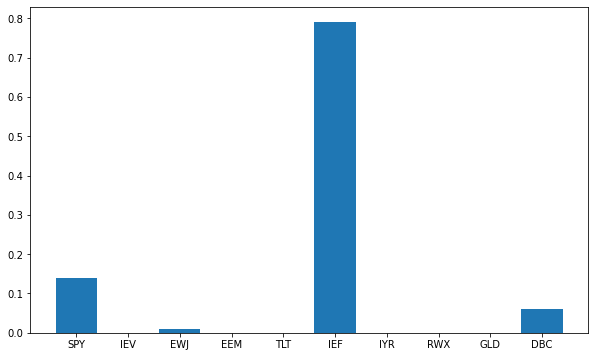

In [135]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x = rets.columns, height = res)
plt.show()

그림에서 알 수 있듯이 앞서 계산된 결과를 이용해 그대로 투자하기에는 문제가 있습니다. 일부 자산은 투자비중이 0%, 즉 전혀 투자하지 않는 반면, 특정 자산에 대부분의 비중을 투자하는 편중된 결과가 나옵니다. 이처럼 변동성이 가장 낮은 종목에 대부분의 비중이 투자되는 구석해(Corner Solution) 문제를 해결하기 위해 각 자산의 최소 및 최대 투자비중 제약조건을 추가해 줄 필요가 있습니다.

구석해 문제를 방지하고, 모든 자산에 골고루 투자하기 위해 개별 투자비중을 최소 5%, 최대 20%로 하는 제약조건을 추가하겠습니다. 이를 $Gx ≤ h$의 형태로 나타내면 다음과 같습니다.

$$\begin{bmatrix}-1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & -1 \\ 1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & 1\end{bmatrix} \begin{bmatrix} w_1 \\  \vdots \\ w_n \end{bmatrix} \le \begin{bmatrix} -0.05 \\  \vdots \\ -0.05 \\ 0.2 \\ \vdots \\ 0.2 \end{bmatrix}$$

다른 조건들은 동일하며, $G$와 $h$에 해당하는 값만 변경됩니다. 이를 적용해 최적값을 구해보도록 하겠습니다.

In [136]:
P = matrix(np.array(covmat), tc = 'd') # 분산-공분산 행렬
q = matrix(np.zeros(10), tc = 'd') # 0 행렬
G = matrix(np.concatenate( (np.diag(np.repeat(-1, 10)), np.diag(np.repeat(1, 10)))) , tc = 'd') # 부등식 제약조건의 좌변
h = matrix(np.concatenate( (np.repeat(-0.05, 10), np.repeat(0.2, 10))) , tc = 'd') # 부등식 제약조건의 우변
A = matrix(np.repeat(1, 10), tc = 'd').T # 등식 제약조건의 좌변
b = matrix(1, tc = 'd') # 등식 제약조건의 우변

sol = solvers.qp(P,q,G,h, A, b)
res = np.array(sol['x']).flatten().round(2)

print(res)

[0.05 0.05 0.05 0.05 0.2  0.2  0.05 0.05 0.19 0.1 ]


변경된 제약조건에 맞게 최소 투자비중은 5%이며, 최대 투자비중은 20% 임을 확인할 수 있습니다. 이로써 구석해 문제가 어느정도 해결되었습니다.

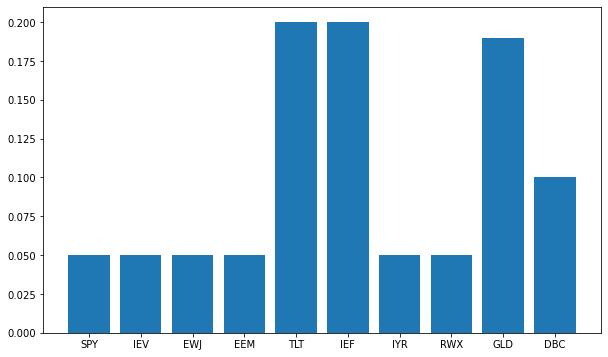

In [137]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x = rets.columns, height = res)
plt.show()

### 14.1.4 각 자산별 제약조건의 추가

투자 규모가 크지 않다면 위에서 추가한 제약조건만으로도 충분히 훌륭한 포트폴리오가 구성됩니다. 그러나 투자 규모가 커지면 추가적인 제약조건들을 고려해야 할 경우가 생깁니다. 벤치마크 비중과의 괴리로 인한 추적오차(Tracking Error)를 고려해야 할 수도 있고, 투자 대상별 거래량을 고려한 제약조건을 추가해야 할 때도 있습니다. 

기존 제약조건에는 자산별로 동일한 최소 및 최대 투자비중 제약조건을 다루었지만, 자산별로 상이한 제약조건이 필요할 경우도 있습니다. 앞의 예에서 $G$와 $h$ 부분을 변경하면 이 또한 어렵지 않게 구현이 가능합니다.

먼저 {numref}`min_const`은 새롭게 설정하고자 하는 각 자산별 최소 및 최대 제약조건입니다.

```{table} 각 자산 별 최소 및 최대 제약조건
:name: min_const
|제약|1|2|3|4|5|6|7|8|9|10|
|---|---|---|---|---|---|---|---|---|---|---
|최소|0.10|0.10|0.05|0.05|0.10|0.10|0.05|0.05|0.03|0.03|
|최대|0.25|0.25|0.20|0.20|0.20|0.20|0.10|0.10|0.08|0.08|
```

이를 $Gx  ≤ h$의 형태로 나타내면 다음과 같습니다.

$$ \begin{bmatrix} -1 & \dots & 0 \\ \vdots & \ddots & \vdots \\
0 & \dots & -1 \\ 1 & \dots & 0 \\ \vdots &  \ddots & \vdots \\
0 & \dots & 1 \\ \\ \end{bmatrix}
\begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_{10} \end{bmatrix} 
= \begin{bmatrix} -w_1 \\ -w_2 \\ -w_3 \\ -w_4 \\ -w_5 \\ -w_6 \\ -w_7 \\ -w_8 \\ -w_9 \\ -w_{10} \\ w_1 \\ w_2 \\ w_3 \\ w_4 \\ w_5 \\ w_6 \\ w_7\\ w_8\\ w_9\\ w_{10} \end{bmatrix} \le \begin{bmatrix} -0.10 \\ -0.10 \\ -0.05 \\ -0.05 \\ -0.10 \\ -0.10 \\ -0.05 \\ -0.05 \\ -0.03 \\ -0.03 \\ 0.25 \\ 0.25 \\ 0.20 \\ 0.20 \\ 0.20 \\ 0.20 \\ 0.10 \\ 0.10 \\ 0.08 \\ 0.08
\end{bmatrix} $$

이를 적용해 최적값을 구해보도록 하겠습니다.

In [138]:
boundary = np.array([-0.10, -0.10, -0.05, -0.05, -0.10, -0.10, -0.05, -0.05, -0.03, -0.03,
                    0.25, 0.25, 0.20, 0.20, 0.20, 0.20, 0.10, 0.10, 0.08, 0.08]) # 부등식 제약조건의 우변

P = matrix(np.array(covmat), tc = 'd') # 분산-공분산 행렬
q = matrix(np.zeros(10), tc = 'd') #0  행렬
G = matrix(np.concatenate( (np.diag(np.repeat(-1, 10)), np.diag(np.repeat(1, 10)))) , tc = 'd') # 부등식 제약조건의 좌변
h = matrix(boundary, tc = 'd') # 부등식 제약조건의 우변
A = matrix(np.repeat(1, 10), tc = 'd').T # 등식 제약조건의 좌변
b = matrix(1, tc = 'd') # 등식 제약조건의 우변

sol = solvers.qp(P,q,G,h, A, b)
res = np.array(sol['x']).flatten().round(2)

print(res)

[0.11 0.1  0.08 0.05 0.2  0.2  0.05 0.05 0.08 0.08]


결괏값을 확인해보면 각 자산별 제약조건 내에 위치함을 확인할 수 있습니다.

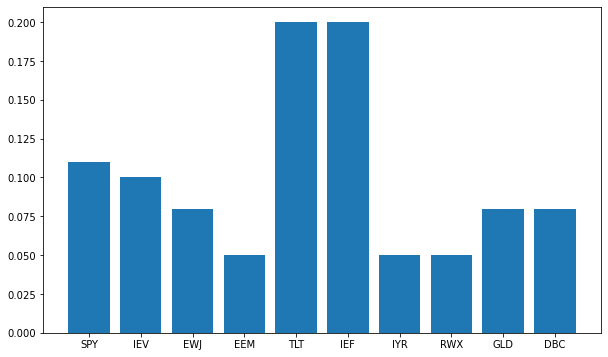

In [139]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x = rets.columns, height = res)
plt.show()

## 14.2 위험균형 포트폴리오

### 14.2.1 minimize() 함수를 이용한 최적화

먼저 위험균형 포트폴리오를 계산하는데 사용되는 최적화 함수에 대해 알아보도록 하겠습니다. scipy.optimize 패키지의 `minimize()` 함수를 사용하며, 그 중에서도 **slsqp(Sequential Least Squares Programming)** 방법을 사용합니다. 해당 함수의 사용 설명서는 다음 사이트에 자세히 나와 있습니다.

```
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

```

해당 함수의 목적함수와 제약조건은 다음과 같습니다.

```{table} minimize() 함수의 목적함수와 제약조건
:name: minimize
| 목적함수 | 제약조건 | 
| --- | --- |
| $ \min f(x)$  | $b(x)≥0,c(x)=0$ |
```

목적함수에서 $f(x)$는 최소화하고자 하는 값입니다. 제약조건에는 부등식 제약조건과 등식 제약조건을 넣을 수 있습니다. `minimize()` 함수의 구성은 다음과 같습니다.

In [ ]:
minimize(fun, x0, method, bounds, constraints, options)

1. fun: 목적함수를 입력합니다.
2. x0: 초기값이며, 일반적으로 모든 x에 대해 동일한 값을 입력합니다.
3. method: 최적화 방법을 입력합니다.
4. bounds: 최적해의 범위를 입력합니다.
5. constraints: 부등식 및 등식 제약조건을 입력합니다.
6. options: 기타 옵션을 입력합니다.

예시를 통해 해당 함수의 사용법을 익혀보도록 하겠습니다. 예시에 사용되는 목적함수와 제약조건은 다음과 같습니다.

- 목적함수
$$\min x_1 x_4(x_1 + x_2 + x_3) + x3$$

- 제약조건
$$x_1 x_2 x_3 x_4 \ge 25$$
$$x_1^2 + x_2^2 + x_3^2 + x_4^2 = 40$$
$$1 \le x_1, x_2, x_3, x_4 \le 5$$

이를 코드로 나타내면 다음과 같습니다.

In [5]:
# 목적식
def obj_function(x) :
    
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    
    return x1*x4*(x1+x2+x3)+x3

# 제약조건 1
def cons_1(x) :
    return x[0]*x[1]*x[2]*x[3] - 25

# 제약조건 2
def cons_2(x) :
    return x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 - 40

1. obj_function: 목적함수에 해당하는 부분을 입력합니다.
2. cons_1: 첫번째 제약조건인 $x_1 x_2 x_3 x_4 \ge 25$ 을 입력합니다. 함수에서는 $b(x) \ge 0$ 형태로 입력해주어야 하므로 25를 좌변으로 넘겨주도록 합니다.
3. cons_2: 두번째 제약조건 역시 $c(x) = 0$ 형태를 만들기 위해 40을 좌변으로 넘겨줍니다.

다음으로 최적해를 구하는 코드를 살펴보겠습니다.

In [6]:
from scipy.optimize import minimize

x0 = [1, 5, 5, 1]
bnds = ((1, 5), ) * 4

constraints = ({'type': 'ineq', 'fun': cons_1},
               {'type': 'eq', 'fun': cons_2})
options = {'ftol': 1e-20, 'maxiter': 800}

result = minimize(fun = obj_function,
                  x0 = x0,
                  method = 'SLSQP',
                  bounds = bnds,
                  constraints = constraints,                      
                  options = options)

1. 초기값인 x0에는 랜덤한 숫자를 입력합니다.
2. 최적해의 범위에 해당하는 $1 \le x_1, x_2, x_3, x_4 \le 5$의 상하한 범위를 튜플 형태로 만들어줍니다.
3. 부등식 제약조건(ineq)에 해당하는 cons_1, 등식 제약조건(eq)에 해당하는 cons_2를 입력합니다.
4. 각종 옵션을 입력합니다. ftol은 tolerance 이며, maxiter는 최대 연산횟수입니다.
5. `minimize()` 함수 내에 위의 값들을 입력해 최적해를 계산합니다.

In [7]:
result

     fun: 17.014017289156026
     jac: array([14.5722754 ,  1.37940812,  2.37940812,  9.56414962])
 message: 'Positive directional derivative for linesearch'
    nfev: 104
     nit: 16
    njev: 12
  status: 8
 success: False
       x: array([1.        , 4.74299961, 3.82115002, 1.37940829])

fun은 목적함수의 결과, 즉 최적값을 의미하며, x는 이를 만족하는 해를 의미합니다. 최적해만 선택하는 방법은 다음과 같습니다.

In [8]:
result['x']

array([1.        , 4.74299961, 3.82115002, 1.37940829])

### 14.2.2 주식 60%와 채권 40% 포트폴리오의 위험기여도

포트폴리오를 구성하는 자산들과 전체 위험의 관계를 이해하기 위해서는, 먼저 한계 위험기여도(MRC: Marginal Risk Contribution)와 위험기여도(RC: Risk Contribution)에 대해 알아야 합니다. 한계 위험기여도는 특정 자산의 비중을 한 단위 증가시켰을 때 전체 포트폴리오의 위험의 증가를 나타내는 단위로서, 수학의 편미분과 같은 개념입니다. $i$번째 자산의 한계 위험기여도는 아래와 같이 나타낼 수 있습니다.

$$MRC_i = \frac{\partial\sigma_p}{\partial w_i} $$

$\sqrt {f'(x)} = \frac{f'(x)}{2\sqrt{f(x)}}$인 사실을 이용하면, 한계 위험기여도는 다음과 같이 풀 수 있습니다. 결과적으로 분자는 분산-공분산 행렬과 각 자산의 비중의 곱, 분모는 포트폴리오의 표준편차 형태로 나타납니다.

\begin{equation} 
\begin{split}
\frac{\partial\sigma_p}{\partial w} & = \frac{\partial(\sqrt{w'\Omega w})}{\partial w} \\
& =\frac{\partial(w'\Omega w)}{\partial w} \times \frac{1}{2\sqrt{w'\Omega w}} \\
& =\frac{2\Omega w}{2\sqrt{w'\Omega w}} \\
& =\frac{\Omega w}{\sqrt{w'\Omega w}}
\end{split}
\end{equation} 

위험기여도는 특정 자산이 포트폴리오 내에서 차지하는 위험의 비중입니다. 한계 위험기여도가 큰 자산도 포트폴리오 내에서 비중이 작다면, 포트폴리오 내에서 차지하는 위험의 비중은 작을 것입니다. 반면에, 한계 위험기여도가 작은 자산일지라도 비중이 압도적으로 많다면, 포트폴리오 내에서 차지하는 위험의 비중은 클 것입니다.

결과적으로 $i$번째 자산의 위험기여도는, $i$번째 자산의 한계 위험기여도와 포트폴리오 내 비중의 곱으로 이루어집니다.

$$RC_i = \frac{\partial\sigma_p}{\partial w_i} \times w_i$$
위험기여도를 코드로 나타내면 다음과 같습니다. 먼저 포트폴리오 비중인 $w$와 분산-공분산 행렬인 covmat을 이용해 한계 위험기여도(mrc)를 계산합니다. 그 후 비중 $w$를 곱해 위험기여도를 계산해 준 후 합계가 1이 되도록 표준화를 해줍니다. 이를 코드로 나타내면 다음과 같습니다.

In [5]:
import pandas as pd
import numpy as np

def RC(w, covmat) :
    weight = np.array(w)
    variance = weight.T @ covmat @ weight
    sigma = variance ** 0.5
    mrc = 1/sigma * (weight @ covmat)
    rc = mrc * weight
    rc = rc / rc.sum()
    return(rc)

실제로 자산들 내 위험기여도가 어떻게 차이나는지 살펴보겠습니다. 자산배분에서 가장 많이 사용되는 투자방법은 주식에 60%, 채권에 40% 가량의 비율로 투자하는 것입니다. 주식과 채권이 서로 상관관계가 낮아 분산효과가 있다는 점, 장기적으로 주식이 채권에 비해 장기적으로 수익률이 높다는 점을 감안하면 이는 꽤나 합리적인 방법으로 보입니다.

그러나 눈에 보이는 비중이 60대 40이라도, 포트폴리오 내에서 각 자산이 가지고 있는 위험기여도 60대 40의 비중이 아닌 전혀 다른 비중을 가지고 있습니다.

In [6]:
ret_stock_bond  = rets.loc[:, ['SPY', 'TLT']]
cov_stock_bond = pd.DataFrame.cov(ret_stock_bond)
RC_stock_bond  = RC([0.6, 0.4], cov_stock_bond).round(4)

RC_stock_bond

SPY    0.9705
TLT    0.0295
dtype: float64

1. rets 데이터에서 첫 번째 행은 미국 주식 수익률을, 다섯 번째 행은 미국 장기채를 의미하므로, 해당 부분을 ret_stock_bond 변수에 지정합니다.
2. `cov()` 함수를 이용해 두 자산의 분산-공분산 행렬을 만들어줍니다.
3. 위에서 만든 RC 함수를 통해 자산별 위험기여도를 계산합니다.

주식과 채권이 가지는 위험기여도를 살펴보면 투자 비중인 60%, 40%와는 전혀 다른 위험 비중을 보입니다. 즉, 주식이 포트폴리오 위험의 대부분을 차지하고 있습니다.

### 14.2.3 위험균형 포트폴리오 계산하기

특정 자산이 포트폴리오의 위험을 대부분 차지하는 문제를 막고, 모든 자산이 동일한 위험기여도를 가지는 포트폴리오가 위험균형 포트폴리오(Risk Parity Portfolio) 혹은 동일 위험기여도 포트폴리오(Equal Risk Contribution Portfolio)입니다. 이를 수식으로 쓰면 다음과 같습니다.

$$RC_1 = RC_2 = \dots = RC_n$$
$$\frac{\partial\sigma_p}{\partial w_1} \times w_1 = \frac{\partial\sigma_p}{\partial w_2} \times w_2
= \dots = \frac{\partial\sigma_p}{\partial w_n} \times w_n = \frac{1}{n}$$

이를 `minimize()` 함수에 맞게 변경하면 다음과 같습니다.

목적함수: $min \sum_{i=1}^{n}(Target\ RC_{i} - RC_{i})^2$

제약조건: $w_i \ge 0, \sum_{i=1}^{n}w_i = 1$

이 중 $Target\ RC_{i}$는 $i$ 자산의 목표 위험 기여도 이며, $RC_{i}$는 $i$ 자산의 실제 위험 기여도 입니다. 위험균형 포트폴리오는 모든 자산의 위험기여도가 $\frac{1}{n}$로 동일해야 합니다. 따라서 모든 자산의 $Tartget\ RC_i$를 $\frac{1}{n}$로 두면 이론적으로 목적함수는 0이 되어야 하며, 해당값이 최소가 되는 최적해를 찾으면 됩니다. 제약조건의 경우 투자비중이 0보다 크고, 합이 1인 조건을 의미합니다. 이를 코드로 나타내면 다음과 같습니다.

In [23]:
# 목적식
def RiskParity_objective(weight) :
    
    weight = np.array(weight)
    variance = weight.T @ covmat @ weight
    sigma = variance ** 0.5
    mrc = 1/sigma * (weight @ covmat)
    rc = weight * mrc
    rc = rc / rc.sum()
    
    target = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    risk_diffs = rc - target
    sum_risk_diffs_squared = sum(np.square(risk_diffs.values))
    return (sum_risk_diffs_squared)

# 제약조건 1: 비중이 0보다 클 것
def weight_longonly(x) :
    return(x)

# 제약조건 2: 합계가 1
def weight_sum_constraint(x) :
    return(x.sum() - 1.0 )

1. 목적함수에서는 각 자산의 위험기여도를 계산한 후, 타겟을 0.1로 동일하게 둡니다. 둘간의 차이의 제곱을 더해준 값을 반환하며, `minimize()` 함수에서는 이 값이 최소가 되는 해인 weight를 계산합니다.
2. 투자비중이 0보다 큰 제약조건을 입력합니다.
3. 투자비중의 합계가 1인 제약조건을 입력하며, 함수의 $c(x)=0$ 형태를 맞춰주기 위해 1을 좌변으로 옮겨줍니다.

위에서 입력한 목적함수와 제약조건을 바탕으로 위험균형 포트폴리오를 만드는 자산별 투자비중을 구하도록 하겠습니다.

In [27]:
from scipy.optimize import minimize
import numpy as np
    
inv_vol = 1 / np.diag(covmat)
inv_vol = inv_vol / sum(inv_vol)

bnds = ((0.0, 1.0), ) * 10
constraints = ({'type': 'ineq', 'fun': weight_longonly},
               {'type': 'eq', 'fun': weight_sum_constraint})               
options = {'ftol': 1e-20, 'maxiter': 800}

result = minimize(fun = RiskParity_objective,
                  x0 = inv_vol,
                  method = 'SLSQP',
                  bounds = bnds,
                  constraints = constraints,                      
                  options = options)

1. `minimize()` 함수를 이용한 최적화는 초기값에 상당한 영향을 받습니다. 위험균형 포트폴리오는 변동성의 역수와 어느 정도 비례하므로, 초기값으로 이를 설정해줍니다.
2. 최적해의 범위, 즉 투자비중의 범위인 0과 1을 튜플을 입력합니다.
3. 부등식과 등식 제약조건을 입력합니다.
4. 옵션을 입력합니다.
4. 목적함수와 제약조건을 만족하는 투자비중을 계산합니다.

In [28]:
result['x'].round(2)

array([0.06, 0.05, 0.06, 0.04, 0.17, 0.37, 0.04, 0.05, 0.09, 0.08])

위험균형 포트폴리오를 만족하는 자산별 투자비중이 계산되었습니다. 이를 그림으로 나타내보도록 하겠습니다.

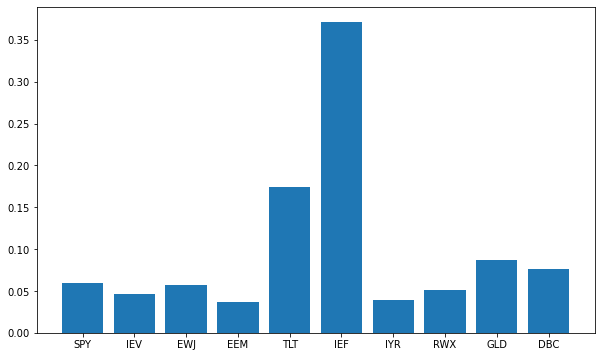

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x = rets.columns, height = result['x'])
plt.show()

위에서 계산된 비중이 위험균형 포트폴리오를 만족하는지, 앞서 만든 `RC()` 함수를 통해 각 자산별 위험기여도를 계산해보겠습니다.

In [29]:
RC(result['x'], covmat).round(2)

SPY    0.1
IEV    0.1
EWJ    0.1
EEM    0.1
TLT    0.1
IEF    0.1
IYR    0.1
RWX    0.1
GLD    0.1
DBC    0.1
dtype: float64

모든 자산의 위험기여도가 0.1로 동일함을 알 수 있습니다.

### 14.2.4 위험예산 포트폴리오

모든 자산의 위험기여도가 동일한 값이 아닌, 자산별로 다른 위험기여도를 가지는 포트폴리오를 구성해야 할 경우도 있습니다. 이러한 포트폴리오를 위험예산 포트폴리오(Risk Budget Portfolio)라고 합니다. 위험균형 포트폴리오 역시 각 자산의 위험예산이 $\frac{1}{n}$로 동일한 특수 형태이며, `minimize()` 함수를 이용하면 이 역시 손쉽게 구현할 수 있습니다.

먼저 각 자산 별 위험예산을 {numref}`risk_contri`과 같이 정합니다. 1\~4번 자산은 각각 15%씩, 5\~6번 자산은 각각 10%씩, 7\~10번 자산은 각각 5%씩 위험예산을 부여하고자 합니다.

```{table} 위험예산 포트폴리오 예시
:name: risk_contri
|자산|1|2|3|4|5|6|7|8|9|10|
|---|---|---|---|---|---|---|---|---|---|---
|예산|0.15|0.15|0.15|0.15|0.10|0.10|0.05|0.05|0.05|0.05|
```

In [31]:
def RiskParity_objective(weight) :
    
    weight = np.array(weight)
    variance = weight.T @ covmat @ weight
    sigma = variance ** 0.5
    mrc = 1/sigma * (weight @ covmat)
    rc = weight * mrc
    rc = rc / rc.sum()
    
    target = np.array([0.15, 0.15, 0.15, 0.15, 0.10, 0.10, 0.05, 0.05, 0.05, 0.05])
    risk_diffs = rc - target
    sum_risk_diffs_squared = np.sum(np.square(risk_diffs.values))
    return (sum_risk_diffs_squared)

# 제약조건 1: 비중이 0보다 클 것
def weight_longonly(x) :
    return(x)

# 제약조건 2: 합계가 1
def weight_sum_constraint(x) :
    return(x.sum() - 1.0 )

    
inv_vol = 1 / np.diag(covmat)
inv_vol = inv_vol / sum(inv_vol)

constraints = ({'type': 'ineq', 'fun': weight_longonly},
               {'type': 'eq', 'fun': weight_sum_constraint})               
options = {'ftol': 1e-20, 'maxiter': 800}

result = minimize(fun = RiskParity_objective,
                  x0 = inv_vol,
                  method = 'SLSQP',
                  constraints = constraints,                      
                  options = options)

앞서의 위험균형 포트폴리오와 대부분의 코드가 동일하며, target 부분만 각 위험예산으로 변경되었습니다. 즉, 각 자산별 목표 위험기여도와 실제 위험기여도 간의 차의 제곱이 최소화가 되는 형태입니다.

In [32]:
result['x']

array([0.08435082, 0.06676064, 0.07861654, 0.05305103, 0.18153775,
       0.3924763 , 0.01983651, 0.02526027, 0.05431189, 0.04379825])

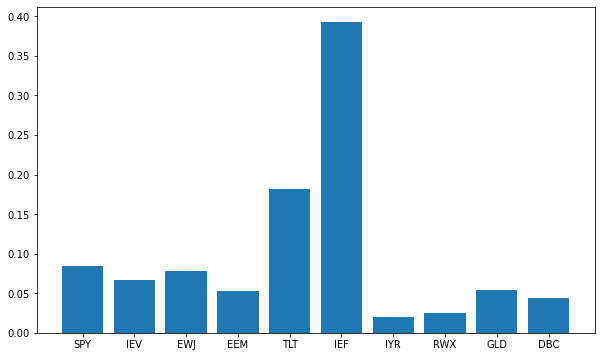

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x = rets.columns, height = result['x'])
plt.show()

위험예산 포트폴리오를 만족하는 자산별 투자비중이 계산되었습니다. `RC()` 함수를 통해 각 자산별 위험기여도를 계산해보겠습니다.

In [34]:
RC(result['x'], covmat)

SPY    0.15
IEV    0.15
EWJ    0.15
EEM    0.15
TLT    0.10
IEF    0.10
IYR    0.05
RWX    0.05
GLD    0.05
DBC    0.05
dtype: float64

각 자산의 위험기여도가 목표치와 동일함이 확인됩니다.